In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer, mean_squared_error
import lightgbm as lgb
import warnings

warnings.filterwarnings('ignore')

In [2]:
#  Load Data
print("Loading data...")
try:
    train_df = pd.read_csv('/content/train.csv')
    test_df = pd.read_csv('/content/test.csv')
    sample_submission = pd.read_csv('/content/sample_test_out.csv')
    print("Data loaded successfully.")
    print(f"Training data shape: {train_df.shape}")
    print(f"Test data shape: {test_df.shape}")
except FileNotFoundError:
    print("Error: Dataset files not found. Make sure '/content/train.csv' and '/content/test.csv' exist.")
    exit()

Loading data...
Data loaded successfully.
Training data shape: (75000, 4)
Test data shape: (75000, 3)



Starting Exploratory Data Analysis...


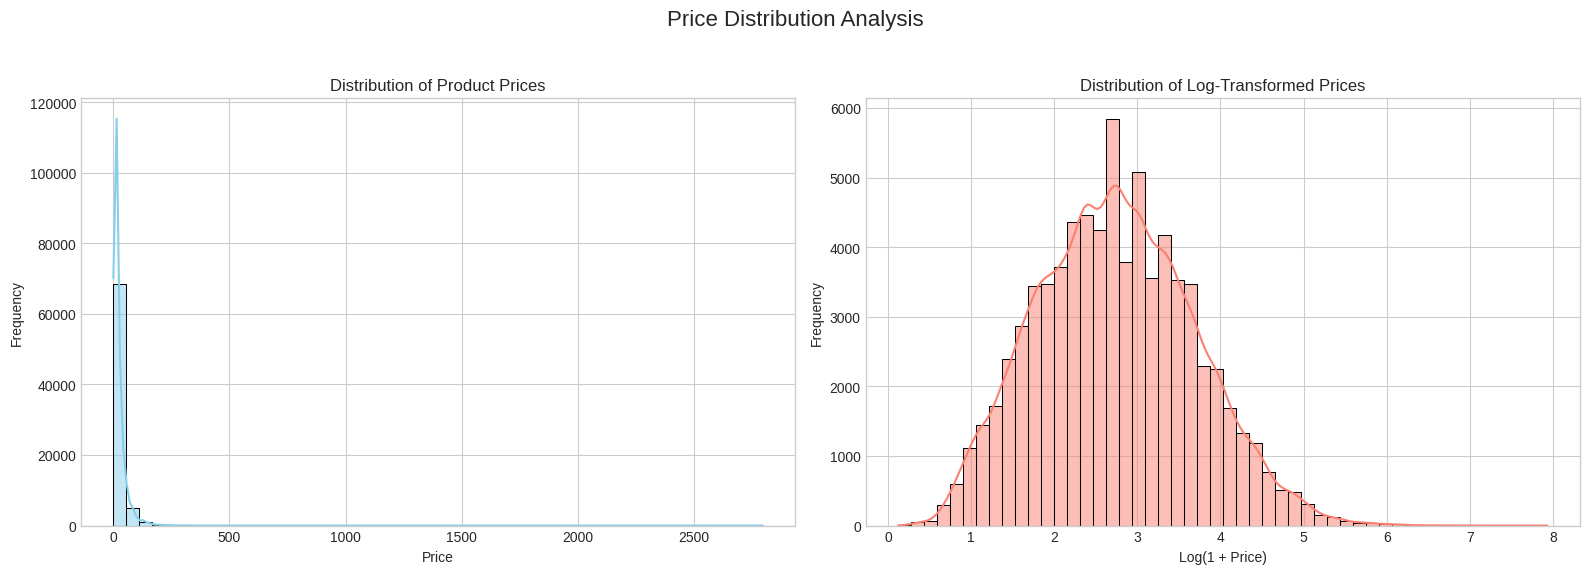


Price Statistics:
count    75000.000000
mean        23.647654
std         33.376932
min          0.130000
25%          6.795000
50%         14.000000
75%         28.625000
max       2796.000000
Name: price, dtype: float64

Generating Word Cloud for 'catalog_content'...


In [3]:
#   Exploratory Data Analysis (EDA)
print("\nStarting Exploratory Data Analysis...")

#   Analyze the 'price' Target Variable
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histogram of price
sns.histplot(train_df['price'], bins=50, kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Distribution of Product Prices')
axes[0].set_xlabel('Price')
axes[0].set_ylabel('Frequency')

# Log-transformed histogram of price
# We use np.log1p which is log(1+x) to handle potential zero prices
train_df['log_price'] = np.log1p(train_df['price'])
sns.histplot(train_df['log_price'], bins=50, kde=True, ax=axes[1], color='salmon')
axes[1].set_title('Distribution of Log-Transformed Prices')
axes[1].set_xlabel('Log(1 + Price)')
axes[1].set_ylabel('Frequency')

plt.suptitle('Price Distribution Analysis', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("\nPrice Statistics:")
print(train_df['price'].describe())


#   Analyze 'catalog_content'
print("\nGenerating Word Cloud for 'catalog_content'...")
# Combine all text content into a single string
text = ' '.join(train_df['catalog_content'].dropna().astype(str))

# Define stopwords
stopwords = set(STOPWORDS)
stopwords.update(["oz", "pack", "count", "size", "inch"]) # Add domain-specific stopwords

# Generate word cloud
wordcloud = WordCloud(
    stopwords=stopwords,
    background_color="white",
    max_words=200,
    width=800,
    height=400,
    contour_width=3,
    contour_color='steelblue'
).generate(text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most Frequent Words in Product Catalog Content")
plt.show()

In [4]:
#   Data Preparation & Feature Engineering
print("\nStarting Data Preparation and Feature Engineering...")

def preprocess_data(df):
    """Applies cleaning and feature engineering to the dataframe."""
    df_copy = df.copy()

    # Fill missing content with an empty string
    df_copy['catalog_content'] = df_copy['catalog_content'].fillna('').astype(str)

    #   Clean Text
    # Convert to lowercase
    df_copy['cleaned_content'] = df_copy['catalog_content'].str.lower()
    # Remove punctuation
    df_copy['cleaned_content'] = df_copy['cleaned_content'].str.replace(r'[^\w\s]', '', regex=True)

    #  Extract Item Pack Quantity (IPQ)
    # Regex to find patterns like "pack of 6", "6-pack", "6 count", etc.
    # It looks for a number followed by common packaging words.
    df_copy['ipq'] = df_copy['cleaned_content'].str.extract(r'(\d+)\s*(?:pack|count|pk|ct)').astype(float).fillna(1)

    return df_copy

train_processed_df = preprocess_data(train_df)
test_processed_df = preprocess_data(test_df)

print("Feature Engineering complete. 'ipq' extracted.")
print("Sample of processed data:")
print(train_processed_df[['catalog_content', 'ipq']].head())


#   Vectorize Text using TF-IDF
print("\nVectorizing text data with TF-IDF...")
tfidf_vectorizer = TfidfVectorizer(
    stop_words='english',
    ngram_range=(1, 2), # Use both unigrams and bigrams
    max_features=20000, # Limit the number of features
    min_df=3,           # Ignore terms with a frequency lower than 3
    max_df=0.9          # Ignore terms with a frequency higher than 90%
)

# Fit on training data and transform both train and test data
X_train_text = tfidf_vectorizer.fit_transform(train_processed_df['cleaned_content'])
X_test_text = tfidf_vectorizer.transform(test_processed_df['cleaned_content'])

print(f"TF-IDF matrix shape for training data: {X_train_text.shape}")

# Combine TF-IDF features with the numerical IPQ feature
from scipy.sparse import hstack
X_train = hstack([X_train_text, train_processed_df[['ipq']].values]).tocsr() # Convert to CSR
X_test = hstack([X_test_text, test_processed_df[['ipq']].values]).tocsr()   # Convert to CSR
y_train = train_processed_df['log_price'].values

print(f"Final training feature matrix shape: {X_train.shape}")



Starting Data Preparation and Feature Engineering...
Feature Engineering complete. 'ipq' extracted.
Sample of processed data:
                                     catalog_content  ipq
0  Item Name: La Victoria Green Taco Sauce Mild, ...  1.0
1  Item Name: Salerno Cookies, The Original Butte...  1.0
2  Item Name: Bear Creek Hearty Soup Bowl, Creamy...  1.0
3  Item Name: Judee’s Blue Cheese Powder 11.25 oz...  1.0
4  Item Name: kedem Sherry Cooking Wine, 12.7 Oun...  1.0

Vectorizing text data with TF-IDF...
TF-IDF matrix shape for training data: (75000, 20000)
Final training feature matrix shape: (75000, 20001)


In [17]:
#   Modeling (Baseline)
print("\nStarting baseline model training (LightGBM)...")

# Define the SMAPE metric for evaluation
def smape(y_true, y_pred):
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    # Handle the case where the denominator is zero
    denominator[denominator == 0] = 1e-9 # Avoid division by zero
    return np.mean(numerator / denominator) * 100

# We need to use expm1 because the model predicts log_price
def smape_expm1(y_true_log, y_pred_log):
    y_true = np.expm1(y_true_log)
    y_pred = np.expm1(y_pred_log)
    return smape(y_true, y_pred)

smape_scorer = make_scorer(smape_expm1, greater_is_better=False) # Lower is better

# LightGBM Model Parameters
lgb_params = {
    'objective': 'regression_l1',
    'metric': 'rmse',
    'n_estimators': 2000,
    'learning_rate': 0.02,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'lambda_l1': 0.1,
    'lambda_l2': 0.1,
    'num_leaves': 31,
    'verbose': -1,
    'n_jobs': -1,
    'seed': 42,
    'boosting_type': 'gbdt',
}

# Cross-validation training
NFOLDS = 5
folds = KFold(n_splits=NFOLDS, shuffle=True, random_state=42)
oof_preds = np.zeros(X_train.shape[0])
sub_preds = np.zeros(X_test.shape[0])

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train, y_train)):
    X_train_fold, y_train_fold = X_train[train_idx], y_train[train_idx]
    X_valid_fold, y_valid_fold = X_train[valid_idx], y_train[valid_idx]

    model = lgb.LGBMRegressor(**lgb_params)
    model.fit(X_train_fold, y_train_fold,
              eval_set=[(X_valid_fold, y_valid_fold)],
              eval_metric='rmse',
              callbacks=[lgb.early_stopping(100, verbose=False)])

    oof_preds[valid_idx] = model.predict(X_valid_fold)
    sub_preds += model.predict(X_test) / folds.n_splits

    fold_smape = smape_expm1(y_valid_fold, oof_preds[valid_idx])
    print(f"Fold {n_fold+1} SMAPE: {fold_smape:.4f}")

overall_smape = smape_expm1(y_train, oof_preds)
print(f"\nOverall CV SMAPE: {overall_smape:.4f}")



Starting baseline model training (LightGBM)...
Fold 1 SMAPE: 52.9199
Fold 2 SMAPE: 51.8830
Fold 3 SMAPE: 52.2733
Fold 4 SMAPE: 51.5199
Fold 5 SMAPE: 52.2810

Overall CV SMAPE: 52.1754


In [7]:
import pandas as pd
import numpy as np
import re
import os
from tqdm import tqdm

In [8]:
# NLP
from sklearn.feature_extraction.text import TfidfVectorizer

In [9]:
# Image Processing
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image

In [10]:
# Modeling
import lightgbm as lgb
from scipy.sparse import hstack, csr_matrix

In [11]:
#  Configuration
DATA_DIR = '/content/' # Corrected data directory
IMAGE_DIR = 'images/' # Directory to save downloaded images
MODEL_OUTPUT_PATH = 'test_out.csv'

# Ensure image directory exists
os.makedirs(IMAGE_DIR, exist_ok=True)

In [12]:
#  Data Loading
print("Loading data...")
train_df = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))
test_df = pd.read_csv(os.path.join(DATA_DIR, 'test.csv'))
sample_submission_df = pd.read_csv(os.path.join(DATA_DIR, 'sample_test_out.csv'))

# For development, you can use a smaller sample
# train_df = train_df.sample(n=5000, random_state=42)
# test_df = test_df.sample(n=1000, random_state=42)

print(f"Train data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")

Loading data...
Train data shape: (75000, 4)
Test data shape: (75000, 3)


In [ ]:
#  Feature Engineering

# A. Text Features
print("\nEngineering text features...")

def clean_text(text):
    """Basic text cleaning."""
    text = str(text).lower()
    text = re.sub(r'[^\w\s]', '', text) # Remove punctuation
    return text

def extract_ipq(text):
    """Extract Item Pack Quantity (IPQ) using regex."""
    text = str(text).lower()
    # Look for patterns like "ipq: 2", "pack of 6", "count: 12"
    match = re.search(r'(?:ipq|pack of|count|pack):?\s*(\d+)', text)
    if match:
        return int(match.group(1))
    return 1 # Default to 1 if not found

# Apply text processing functions
for df in [train_df, test_df]:
    df['ipq'] = df['catalog_content'].apply(extract_ipq)
    df['cleaned_content'] = df['catalog_content'].apply(clean_text)

# Vectorize text using TF-IDF
print("Applying TF-IDF...")
tfidf_vectorizer = TfidfVectorizer(
    stop_words='english',
    max_features=20000, # Limit features to prevent memory issues
    ngram_range=(1, 2)   # Include bigrams
)

X_train_text = tfidf_vectorizer.fit_transform(train_df['cleaned_content'])
X_test_text = tfidf_vectorizer.transform(test_df['cleaned_content'])

print(f"TF-IDF train shape: {X_train_text.shape}")
print(f"TF-IDF test shape: {X_test_text.shape}")


#  Image Features
print("\nEngineering image features...")

# Download images (assuming src/utils.py is available)
try:
    from src.utils import download_images
    print("Downloading train images...")
    download_images(train_df, IMAGE_DIR)
    print("Downloading test images...")
    download_images(test_df, IMAGE_DIR)
except ImportError:
    print("Warning: src/utils.py not found. Skipping image download.")
    print("Make sure images are already in the IMAGE_DIR.")

# Set up pre-trained ResNet50 model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load a pre-trained ResNet50 model and remove the final classification layer
resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2).to(device)
resnet.fc = torch.nn.Identity() # Remove the final layer
resnet.eval()

# Define image transformations
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def get_image_embedding(sample_id):
    """Loads an image, processes it, and returns its embedding."""
    image_path = os.path.join(IMAGE_DIR, f"{sample_id}.jpg")
    try:
        image = Image.open(image_path).convert("RGB")
        image_tensor = preprocess(image).unsqueeze(0).to(device)
        with torch.no_grad():
            embedding = resnet(image_tensor)
        return embedding.cpu().numpy().flatten()
    except (FileNotFoundError, OSError):
        # Return a zero vector if image is missing or corrupt
        return np.zeros(2048) # ResNet50 output feature size is 2048

# Generate embeddings for train and test sets
print("Generating image embeddings for training data...")
train_image_features = np.array([get_image_embedding(sid) for sid in tqdm(train_df['sample_id'])])

print("Generating image embeddings for test data...")
test_image_features = np.array([get_image_embedding(sid) for sid in tqdm(test_df['sample_id'])])

print(f"Train image features shape: {train_image_features.shape}")
print(f"Test image features shape: {test_image_features.shape}")


#  Combine All Features
print("\nCombining all features...")

# Extract numerical features
X_train_numerical = train_df[['ipq']].values
X_test_numerical = test_df[['ipq']].values

# Use hstack to combine sparse (TF-IDF) and dense (numerical, image) features
X_train_combined = hstack([
    X_train_text,
    csr_matrix(X_train_numerical),
    csr_matrix(train_image_features)
]).tocsr()

X_test_combined = hstack([
    X_test_text,
    csr_matrix(X_test_numerical),
    csr_matrix(test_image_features)
]).tocsr()

print(f"Final combined train features shape: {X_train_combined.shape}")
print(f"Final combined test features shape: {X_test_combined.shape}")


Engineering text features...
Applying TF-IDF...
TF-IDF train shape: (75000, 20000)
TF-IDF test shape: (75000, 20000)

Engineering image features...
Make sure images are already in the IMAGE_DIR.
Using device: cpu
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 129MB/s]


Generating image embeddings for training data...


100%|██████████| 75000/75000 [00:02<00:00, 35535.46it/s]


Generating image embeddings for test data...


100%|██████████| 75000/75000 [00:03<00:00, 23427.85it/s]


Train image features shape: (75000, 2048)
Test image features shape: (75000, 2048)

Combining all features...
Final combined train features shape: (75000, 22049)
Final combined test features shape: (75000, 22049)


In [ ]:
#  Model Training
print("\nTraining LightGBM model...")

# Target variable transformation (log transform) for better performance
y_train = np.log1p(train_df['price'])

# LightGBM model parameters (tuned for a good balance of speed and accuracy)
lgbm_params = {
    'objective': 'regression_l1', # MAE, robust to outliers
    'metric': 'rmse',
    'n_estimators': 2000,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'lambda_l1': 0.1,
    'lambda_l2': 0.1,
    'num_leaves': 31,
    'verbose': -1,
    'n_jobs': -1,
    'seed': 42,
    'boosting_type': 'gbdt',
}

model = lgb.LGBMRegressor(**lgbm_params)

# Train the model
model.fit(X_train_combined, y_train,
          eval_set=[(X_train_combined, y_train)],
          eval_metric='rmse',
          callbacks=[lgb.early_stopping(100, verbose=True)])


Training LightGBM model...


LGBMRegressor(bagging_fraction=0.8, bagging_freq=1, feature_fraction=0.8,
              lambda_l1=0.1, lambda_l2=0.1, learning_rate=0.05, metric='rmse',
              n_estimators=2000, n_jobs=-1, objective='regression_l1', seed=42,
              verbose=-1)

In [16]:
#  Prediction and Submission
print("\nGenerating predictions...")

# Predict on the test set
log_predictions = model.predict(X_test_combined)

# Inverse transform the predictions to get the actual price
predictions = np.expm1(log_predictions)

# Ensure prices are positive
predictions[predictions < 0] = 0

# Create the submission file
submission_df = pd.DataFrame({'sample_id': test_df['sample_id'], 'price': predictions})

# Save the submission file
submission_df.to_csv(MODEL_OUTPUT_PATH, index=False)

print(f"\nSubmission file created successfully at: {MODEL_OUTPUT_PATH}")
print("Top 5 predictions:")
print(submission_df.head())


Generating predictions...

Submission file created successfully at: test_out.csv
Top 5 predictions:
   sample_id      price
0     100179  13.203962
1     245611  18.446443
2     146263  20.720048
3      95658  12.583882
4      36806  34.098982
